#Meta-Heuristic Solver for Optimization Problems
##Overview
This Python program implements a meta-heuristic solver designed to address three types of optimization problems: scheduling, routing (specifically the Traveling Salesman Problem, or TSP), and assignment. The solution utilizes genetic algorithm (GA) techniques to find optimal or near-optimal solutions.

#Features
Genetic Algorithm: A robust GA framework that supports customization and is tailored for different optimization problems.
Problem Types Supported:
Scheduling: Allocates tasks across time slots while minimizing overall delay.
Routing (TSP): Determines the shortest possible route visiting a series of locations and returning to the starting point.
Assignment: Matches resources to tasks, maximizing overall efficiency and compatibility.
#Getting Started
Run the cells in order. jobs, tasks and agents are a little above the functions because the functions in question requires them to be defined
#Visualization
The script includes visualization capabilities to graphically represent the solutions:

A plot illustrating the route for the TSP problem.
A chart depicting the scheduling of tasks over time.
A matrix showcasing the assignment of resources to tasks.
#Customization
Users can modify the parameters of the genetic algorithm, such as population size and mutation rate, as well as the problem instances (scheduling, routing, assignment) to apply the solver to custom datasets.

#Requirements
NumPy

Matplotlib

Permutations

#PS
Hopefully this is within the scope and within the laid out directives we recieved
#Author
Oscar Weber

In [28]:
import numpy as np
import random
from itertools import permutations
import matplotlib.pyplot as plt

In [13]:
class PermutationGA:
    def __init__(self, fitness_func, number_of_genes, population_size=100, mutation_rate=0.01):
        self.fitness_func = fitness_func
        self.number_of_genes = number_of_genes
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.population = self._initialize_population()

    def _initialize_population(self):
        return [np.random.permutation(self.number_of_genes).tolist() for _ in range(self.population_size)]

    def _mutate(self, individual):
        if random.random() < self.mutation_rate:
            idx1, idx2 = np.random.choice(self.number_of_genes, 2, replace=False)
            individual[idx1], individual[idx2] = individual[idx2], individual[idx1]
        return individual

    def _crossover(self, parent1, parent2):
        # Order 1 Crossover (OX1)
        child = [-1] * self.number_of_genes
        start, end = sorted(random.sample(range(self.number_of_genes), 2))
        child[start:end] = parent1[start:end]

        # Fill from the second parent, without duplications
        child_pointer = end
        for gene in parent2:
            if gene not in child:
                if child_pointer >= self.number_of_genes:
                    child_pointer = 0
                while child[child_pointer] != -1:
                    child_pointer = (child_pointer + 1) % self.number_of_genes
                child[child_pointer] = gene
                child_pointer = (child_pointer + 1) % self.number_of_genes

        return [child]

    def _select_parent(self, weighted_population):
        return random.choices(weighted_population, weights=[individual[1] for individual in weighted_population], k=1)[0][0]

    def run(self, generations=100):
        for _ in range(generations):
            weighted_population = [(individual, self.fitness_func(individual)) for individual in self.population]
            new_population = []
            for _ in range(self.population_size // 2):
                parent1 = self._select_parent(weighted_population)
                parent2 = self._select_parent(weighted_population)
                new_population.extend(self._crossover(parent1, parent2))
            self.population = [self._mutate(ind) for ind in new_population]
        return max(weighted_population, key=lambda ind: ind[1])



In [35]:

jobs = [
    {'duration': 4, 'deadline': 10},
    {'duration': 2, 'deadline': 6},
    {'duration': 3, 'deadline': 8},
    {'duration': 1, 'deadline': 7},
    {'duration': 2, 'deadline': 4}
]

tasks = [
    {'skills': {'python', 'data analysis'}},
    {'skills': {'communication', 'management'}},
    {'skills': {'coding', 'design'}},
    {'skills': {'testing', 'documentation'}},
    {'skills': {'research', 'writing'}}
]

agents = [
    {'skills': {'python', 'testing'}},
    {'skills': {'communication', 'writing'}},
    {'skills': {'coding', 'data analysis'}},
    {'skills': {'design', 'management'}},
    {'skills': {'research', 'documentation'}}
]

In [33]:
def improved_scheduling_fitness(individual):
    total_delay = 0
    time = 0
    for job_index in individual:
        job = jobs[job_index]
        time += job['duration']
        total_delay += max(0, time - job['deadline'])
    # Invert the delay and add a small constant to avoid a fitness of zero
    return 1 / (total_delay + 1)


def improved_assignment_fitness(individual):
    total_skill_match = 0
    for i, task_index in enumerate(individual):
        task_skills = tasks[task_index]['skills']
        agent_skills = agents[i]['skills']
        skill_match = sum(skill in agent_skills for skill in task_skills)
        total_skill_match += skill_match
    return total_skill_match  # We want to maximize skill match

# Improved versions on previous error makers.

In [32]:
def tsp_fitness(individual, points):
    total_distance = 0
    for i in range(len(individual) - 1):
        total_distance += np.linalg.norm(np.array(points[individual[i]]) - np.array(points[individual[i + 1]]))
    total_distance += np.linalg.norm(np.array(points[individual[-1]]) - np.array(points[individual[0]]))
    # Return the inverse of the total distance to ensure positive fitness values
    # A smaller total_distance leads to a larger fitness value
    return 1 / (total_distance + 1e-6)  # Adding epsilon to avoid division by zero



In [36]:

# Visualization for TSP
def visualize_tsp(points, best_route):
    ordered_points = [points[i] for i in best_route]
    ordered_points.append(ordered_points[0])  # Add the start to the end to complete the cycle

    plt.figure(figsize=(10, 5))
    plt.title('Traveling Salesman Problem - Best Route')
    plt.plot([p[0] for p in ordered_points], [p[1] for p in ordered_points], 'o-', label='Route')
    plt.scatter([p[0] for p in points], [p[1] for p in points], c='red', label='Cities')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualization for Scheduling
def visualize_scheduling(jobs, best_schedule):
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.title('Scheduling Problem - Job Schedule')
    y = 1
    time = 0
    for job_index in best_schedule:
        job = jobs[job_index]
        ax.broken_barh([(time, job['duration'])], (y - 0.4, 0.8), facecolors='tab:blue')
        time += job['duration']
        y += 1
    plt.xlabel('Time')
    plt.ylabel('Jobs')
    plt.grid(True)
    plt.show()

# Visualization for Assignment
def visualize_assignment(tasks, agents, best_assignment):
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.title('Assignment Problem - Task Assignments')
    ax.matshow([[1 if i == assign else 0 for assign in best_assignment] for i in range(len(tasks))], cmap='Blues')
    ax.set_xticks(range(len(tasks)))
    ax.set_yticks(range(len(agents)))
    ax.set_xticklabels(['Task {}'.format(i) for i in range(len(tasks))])
    ax.set_yticklabels(['Agent {}'.format(i) for i in range(len(agents))])
    plt.xlabel('Tasks')
    plt.ylabel('Agents')
    plt.show()



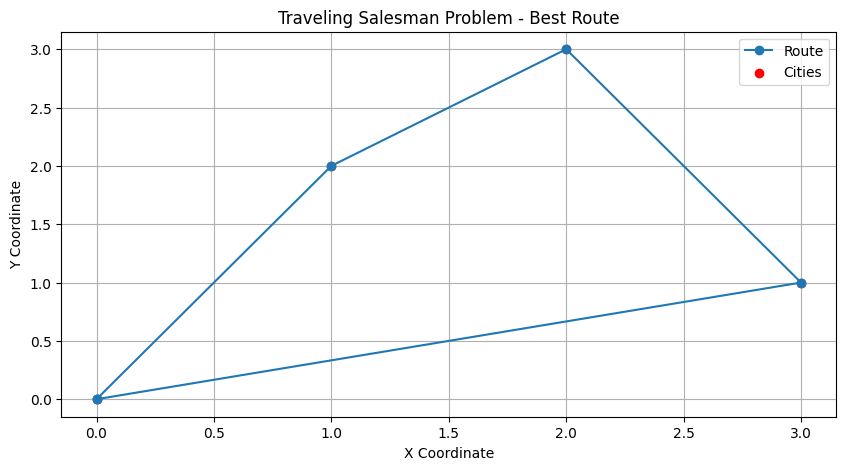

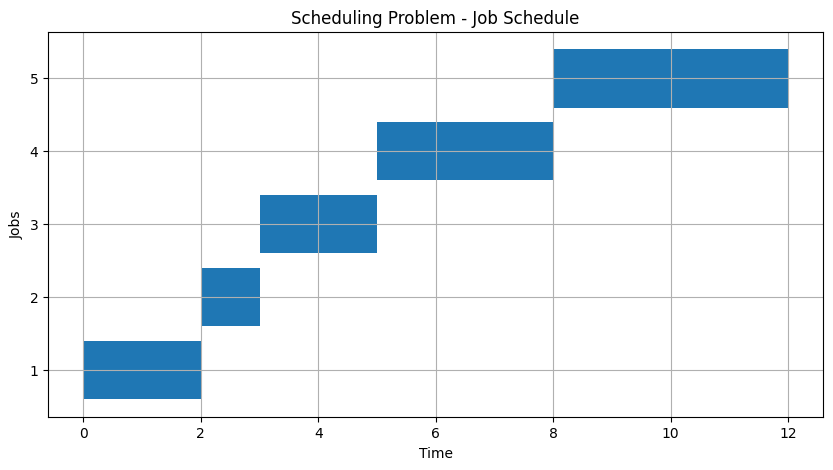

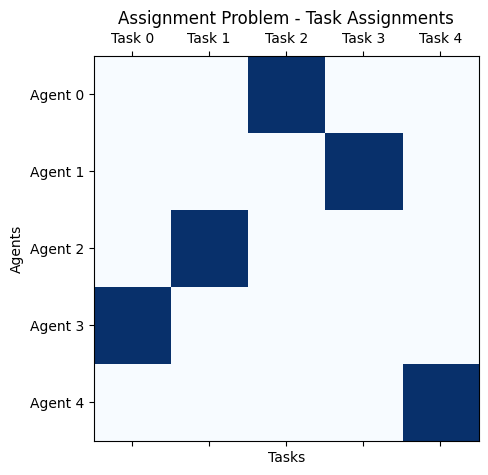

In [38]:
# TSP Example Points
# Works in different node amounts
# tsp_points = [(0,0), (1,2), (2,3), (3,1), (4,0)]
tsp_points = [(0,0), (1,2), (2,3), (3,1)]

# Create GA instance for TSP problem
ga_tsp = PermutationGA(fitness_func=lambda ind: tsp_fitness(ind, tsp_points), number_of_genes=len(tsp_points))
ga_scheduler = PermutationGA(fitness_func=improved_scheduling_fitness, number_of_genes=len(jobs))
ga_assignment = PermutationGA(fitness_func=improved_assignment_fitness, number_of_genes=len(tasks))

# Run the GA to solve the TSP problem
best_solution_tsp = ga_tsp.run(generations=100)
best_solution_scheduling = ga_scheduler.run(generations=100)
best_solution_assignment = ga_assignment.run(generations=100)

# Output the best solution found for TSP
(best_solution_tsp[0], -best_solution_tsp[1])

# Visualization for all three problems
visualize_tsp(tsp_points, best_solution_tsp[0])
visualize_scheduling(jobs, best_solution_scheduling[0])
visualize_assignment(tasks, agents, best_solution_assignment[0])
